# Answering Business Questions using SQL

this project provides me with an opportunity to gain some experience using more complex sql queries/commands building upon my new found knowledge. <br>
I'll be working with a database called 'chinook', which stores data about a given music sales company such as the companies employees, the sales it has made and its customers

# Helper functions 

I shall be using sqlite3 alongside pandas in this mission and so rather than continually calling functions such as 'pd.read_sql_query' and 'sqlite3.connect', I will set up helper functions to simplify this process and make for cleaner code


In [22]:
import sqlite3 as sql
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
#run query hlper function
def run_query(q):
    with sql.connect('chinook.db') as conn:
        return pd.read_sql_query(q,conn)

In [24]:
#run command hlper function
def run_command(c):
    with sql.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

In [25]:
#table status
def show_tables():
    q='SELECT name, type FROM sqlite_master WHERE type IN ("table","view")'
    return run_query(q)

In [26]:
#no tables yet
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Task 1


The Chinook music store has just signed a deal with a new record label. The record label currently has 4 albums from seperate artists and also seperate genres but the store only wishes to sell 3 of them, and <b>only</b> within USA. We are looking to find the 3 most popular genres (based on previous sales) out of the 4 within the USA to decide which albums get chosen.

In [27]:
command = '''
        CREATE VIEW each_track_sale AS
        SELECT 
        il.track_id,
        t.name track_name,
        g.name genre_name,
        t.composer,
        i.billing_country,
        il.quantity
        FROM 
        invoice i
        INNER JOIN invoice_line il ON i.invoice_id = il.invoice_id
        INNER JOIN track t ON il.track_id = t.track_id
        INNER JOIN genre g on g.genre_id = t.genre_id
        WHERE i.billing_country = "USA"
        '''
run_command(command)

In [28]:
#return a dataframe consisting of each genre and its sales stats
query= '''
          WITH total_amount_sales AS
          (SELECT COUNT(il.invoice_line_id)
          FROM invoice i
          INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
          WHERE i.billing_country = "USA")
          
          SELECT 
          genre_name,
          billing_country,
          SUM(quantity) total_sales,
          CAST(SUM(quantity) AS FLOAT)/CAST((SELECT * FROM total_amount_sales) AS FLOAT)*100  percentage
          FROM each_track_sale 
          GROUP BY genre_name
          '''
genre_df = run_query(query)

In [33]:
genre_df=genre_df.set_index('genre_name')

In [29]:
genre_df.head(2)

,genre_name,billing_country,total_sales,percentage
0,Alternative,USA,35,3.330162
1,Alternative & Punk,USA,130,12.369172


<b> genre now contains the columns as above

In [34]:
#use regex to extract the relevant cols
import re
rows_needed = pd.Series(genre_df.index.values).str.contains(r'(Hip.Hop)|(punk)|(blues)|(pop)',flags=re.IGNORECASE)

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:3: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



In [35]:
#the rock/blues/pop/hip-hop rows
genre_relevant = genre_df.reset_index().loc[rows_needed,:].set_index('genre_name')
#the remaining genre rows
genre_not_relevant = genre_df.reset_index().loc[~rows_needed,:].set_index('genre_name')

In [36]:
genre_relevant

,billing_country,total_sales,percentage
genre_name,,,
Alternative & Punk,USA,130,12.369172
Blues,USA,36,3.425309
Hip Hop/Rap,USA,20,1.902950
Pop,USA,22,2.093245


In [37]:
genre_not_relevant

,billing_country,total_sales,percentage
genre_name,,,
Alternative,USA,35,3.330162
Classical,USA,4,0.380590
Easy Listening,USA,13,1.236917
Electronica/Dance,USA,5,0.475737
Heavy Metal,USA,3,0.285442
Jazz,USA,14,1.332065
Latin,USA,22,2.093245
Metal,USA,124,11.798287
R&B/Soul,USA,53,5.042816


In [38]:
#numerical TOTAL stats of the revelant Dataframe
genre_relevant.sum(axis=0,numeric_only=True)

total_sales    208.000000
percentage      19.790676
dtype: float64

In [39]:
#.....
genre_not_relevant.sum(axis=0,numeric_only=True)

total_sales    843.000000
percentage      80.209324
dtype: float64

In [40]:
#check percentages of relevant AND not_relevant genres adds up to 100 to ensure
#all sales within the USA are accounted for
pd.concat([genre_relevant, genre_not_relevant]).sum(axis=0, numeric_only=True)

total_sales    1051.0
percentage      100.0
dtype: float64

In [41]:
#lump all of the other genres together since we are not interested in them
other_genres = genre_not_relevant.sum(axis=0,numeric_only=True)
other_genres.name='other'
genre_all = genre_relevant.append(other_genres)

In [42]:
#total and percentages of out relevant columns plus the SUM of the irrelevant columns
genre_all = genre_all[['total_sales', 'percentage']]

In [43]:
genre_all

,total_sales,percentage
genre_name,,
Alternative & Punk,130.0,12.369172
Blues,36.0,3.425309
Hip Hop/Rap,20.0,1.902950
Pop,22.0,2.093245
other,843.0,80.209324


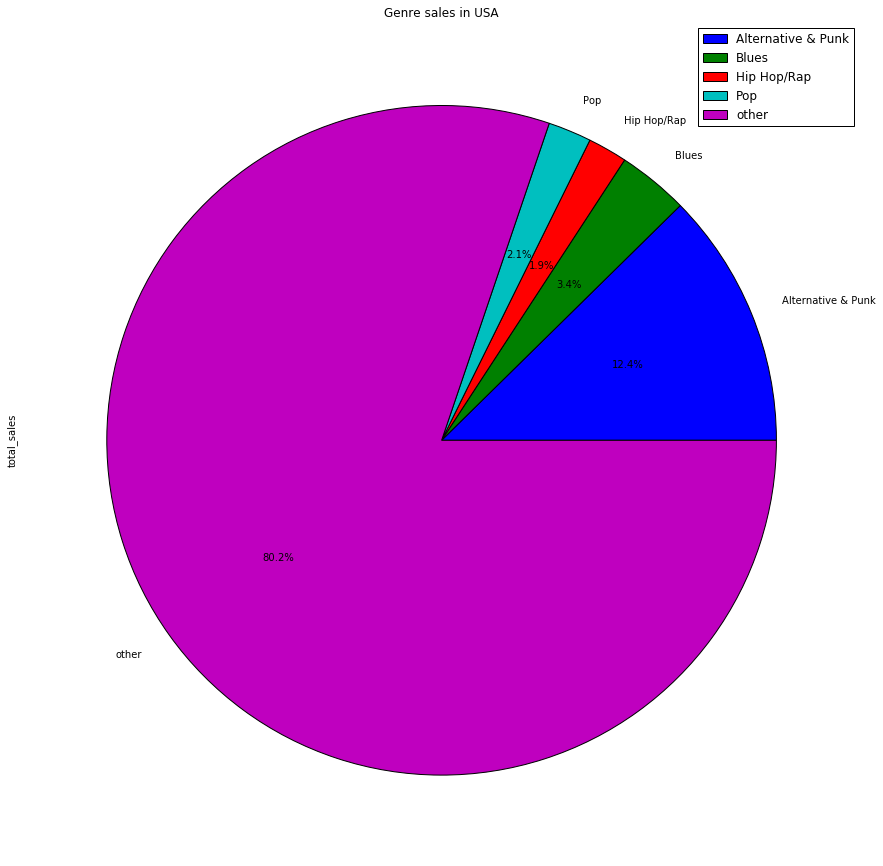

In [44]:
import numpy as np
y_vals=np.array(genre_all['total_sales'])


def show_total_and_percentage(y_val):
        return '{p:0.1f}%'.format(p=y_val)


genre_all.plot(kind='pie',y='total_sales',figsize=(15,15),
               autopct=show_total_and_percentage,
              textprops={'fontsize': 10}, title='Genre sales in USA')

The genre 'punk' tops the list and so will definately be one of the chosen genres. <br>
The remaining 3 seem to be rather similar in popularity with 'Blues' and 'Pop' being slightly more popular than 'Hip-Hop'. Naturally we'll select the first two.

The three chosen genres are:<br>
:Blues<br>
:Punk<br>
:Pop

# Performance of  Sales Agents

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. We have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

In [45]:
#obtain a table showing the total amount customers have spent with each
#Sales Agent, Add attributes from employee table which could impact Sales Agents performance

query = '''

        WITH e2 AS
        (SELECT 
         (first_name || " " || last_name) employee_name,
         employee_id 
         FROM 
         employee
         )

        SELECT 
        (e1.first_name || " " || e1.last_name) sales_agent_name,
        SUM(i.total) total_sales,
        e2.employee_name line_manager,
        e1.hire_date
        FROM
        invoice i 
        INNER JOIN customer c ON c.customer_id=i.customer_id
        INNER JOIN employee e1 ON c.support_rep_id = e1.employee_id
        INNER JOIN e2 ON e2.employee_id = e1.reports_to
        WHERE e1.title = "Sales Support Agent"
        GROUP BY 1
        ORDER BY 2 DESC
'''
sales_agents = run_query(query)
run_query(query)

,sales_agent_name,total_sales,line_manager,hire_date
0,Jane Peacock,1731.51,Nancy Edwards,2017-04-01 00:00:00
1,Margaret Park,1584.00,Nancy Edwards,2017-05-03 00:00:00
2,Steve Johnson,1393.92,Nancy Edwards,2017-10-17 00:00:00


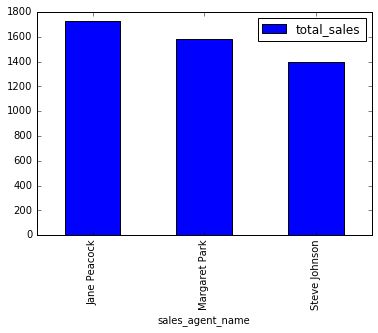

In [46]:
sales_agents.set_index('sales_agent_name').plot(kind='bar')

In [47]:
#hire_date is of form "date -time" 
#extract just the date from the original data, the time is irrelevant, seperating year/month/day in the process
#to store in their respective columns within the sales_agents dataframe
def extract_date(date):
        year_month_day=pd.Series(date).str.extract(r'(?P<year>\d{4})-(?P<day>\d{2})-(?P<month>\d{2})', expand=True)
        year=int(year_month_day.loc[:,'year'][0])
        month=int(year_month_day.loc[:,'month'][0])
        day=int(year_month_day.loc[:,'day'][0])
        lisa = np.array([year,month,day])
        return lisa
        
weas = sales_agents['hire_date'].map(extract_date)
weas = pd.DataFrame(weas.values.tolist(),columns=['hire_year','hire_day','hire_month'])
weas

,hire_year,hire_day,hire_month
0,2017,1,4
1,2017,3,5
2,2017,17,10


In [48]:
#combine these columns with the sales_agents
sales_agents_up = sales_agents.merge(weas,left_index=True,right_index=True)

In [49]:
#no longer need original hire_date
sales_agents_up.drop(columns=['hire_date'], inplace=True)

In [50]:
#sort first by year, then by month , then by day
sales_agents_up.sort_values(inplace=True,by=['hire_year','hire_month','hire_day'])

In [51]:
sales_agents_up

,sales_agent_name,total_sales,line_manager,hire_year,hire_day,hire_month
0,Jane Peacock,1731.51,Nancy Edwards,2017,1,4
1,Margaret Park,1584.00,Nancy Edwards,2017,3,5
2,Steve Johnson,1393.92,Nancy Edwards,2017,17,10


In [52]:
#function to calculate months in current role append to sales_agents_up
#months from current month august 2019
def calculate_months_in_job(row):
    return (2019-row['hire_year'])*12 + (8-row['hire_month'])

sales_agents_up['months_in_job'] = sales_agents_up.apply(calculate_months_in_job,axis=1)

In [53]:
import seaborn as sns

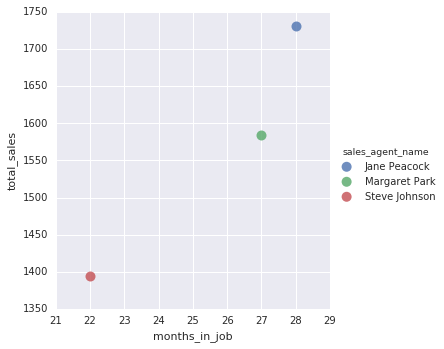

In [54]:
sns.lmplot(x='months_in_job', y='total_sales',
            data=sales_agents_up,
           hue='sales_agent_name',fit_reg=False,
           scatter_kws={"s": 100}
           )

There are only 3 sales agents in the company, Jane, Margaret and Steve
As seen in the tables/graphs/plots Jane has made the most money of the 3, followed by margaret and then Steve <br>
There are a few factors that could be reponsible for the differences, namely the agents 'line manager' and also their experience within the role <br>
Since all 3 have the same line manager it makes sense to differentiate them by experience<br>

If you look at the graph directly above, you can see quite a strong correlation between the total sales and experience(in months) within the role. This indicates that perhaps sales agents perform better as time goes on.

# Countries

We have been directed to calculate data, for each country, on the:<br>
<b>total number of customers<br>
<b>total value of sales<br>
<b>average value of sales per customer<br>
<b>average order value</b><br><br>
Because there are a number of countries with only one customer, we will group these customers as "Other" in our analysis.

In [55]:
#create a view of data sorted by country which includes the above columns
#We first make a view which groups by countries, assigning OTHER to any country with only one customer native to it
#for each of these countries we store the total values we need
create_view = '''
        CREATE VIEW country_data AS
               SELECT
               CASE
                   WHEN COUNT(DISTINCT c.customer_id)=1 THEN "OTHER"
                   ELSE c.country
               END AS country,
               COUNT(DISTINCT c.customer_id) total_customers,
               SUM(i.total) total_value_sales,
               CAST(SUM(i.total) AS FLOAT)/CAST(COUNT(DISTINCT c.customer_id) AS FLOAT) avg_sale_per_customer,
               CAST(SUM(i.total) AS FLOAT)/CAST(COUNT(DISTINCT i.invoice_id) AS FLOAT) avg_order_value,
               COUNT(DISTINCT i.invoice_id) total_invoices
               FROM
               customer c 
               INNER JOIN 
               invoice i ON i.customer_id = c.customer_id
               GROUP BY country'''

run_command(create_view)


In [58]:
#using the view we made above, we now group by country again,
#this time grouping all of the OTHER together and performing the same calculations
#we use an inner query to add and make use of  a sort column which we do not want in the final dataframe

query = '''
       
       SELECT 
       c.country,
       SUM(c.total_customers) AS total_customers, 
       SUM(c.total_value_sales) AS total_value_sales,
       CAST(SUM(c.total_value_sales) AS FLOAT)/CAST(SUM(c.total_customers) AS FLOAT) AS avg_sale_per_customer,
       CAST(SUM(c.total_value_sales) AS FLOAT)/CAST(SUM(c.total_invoices) AS FLOAT) AS avg_order_value
       FROM(
           SELECT 
           *, 
           CASE
               WHEN country="OTHER" THEN 1
               else 0
           END AS order_cheat
           FROM country_data
           ) AS c
           
       GROUP BY c.country
       ORDER BY c.order_cheat ASC, total_value_sales DESC     
       '''
country_data= run_query(query)


In [59]:
country_data

,country,total_customers,total_value_sales,avg_sale_per_customer,avg_order_value
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,OTHER,15,1094.94,72.996000,7.448571


# Visualizing the country data

Now that we have our data, we've been asked to create a series of visualizations which communicate our findings, and then make recommendations on which countries may have potential for growth, so the Chinook marketing team can create some new advertising campaigns

In [60]:
#make country the index
country_data.set_index('country', drop=True, inplace=True)

In [33]:
country_data

,total_customers,total_value_sales,avg_sale_per_customer,avg_order_value
country,,,,
USA,13,1040.49,80.037692,7.942672
Canada,8,535.59,66.948750,7.047237
Brazil,5,427.68,85.536000,7.011148
France,5,389.07,77.814000,7.781400
Germany,4,334.62,83.655000,8.161463
Czech Republic,2,273.24,136.620000,9.108000
United Kingdom,3,245.52,81.840000,8.768571
Portugal,2,185.13,92.565000,6.383793
India,2,183.15,91.575000,8.721429


In [61]:
#colormap to use in cnojuction with plt.cm.Access so all graphs 
#map the same countries to the same colors
colors=[plt.cm.Accent(i) for i in np.linspace(0,1,country_data.shape[0])]

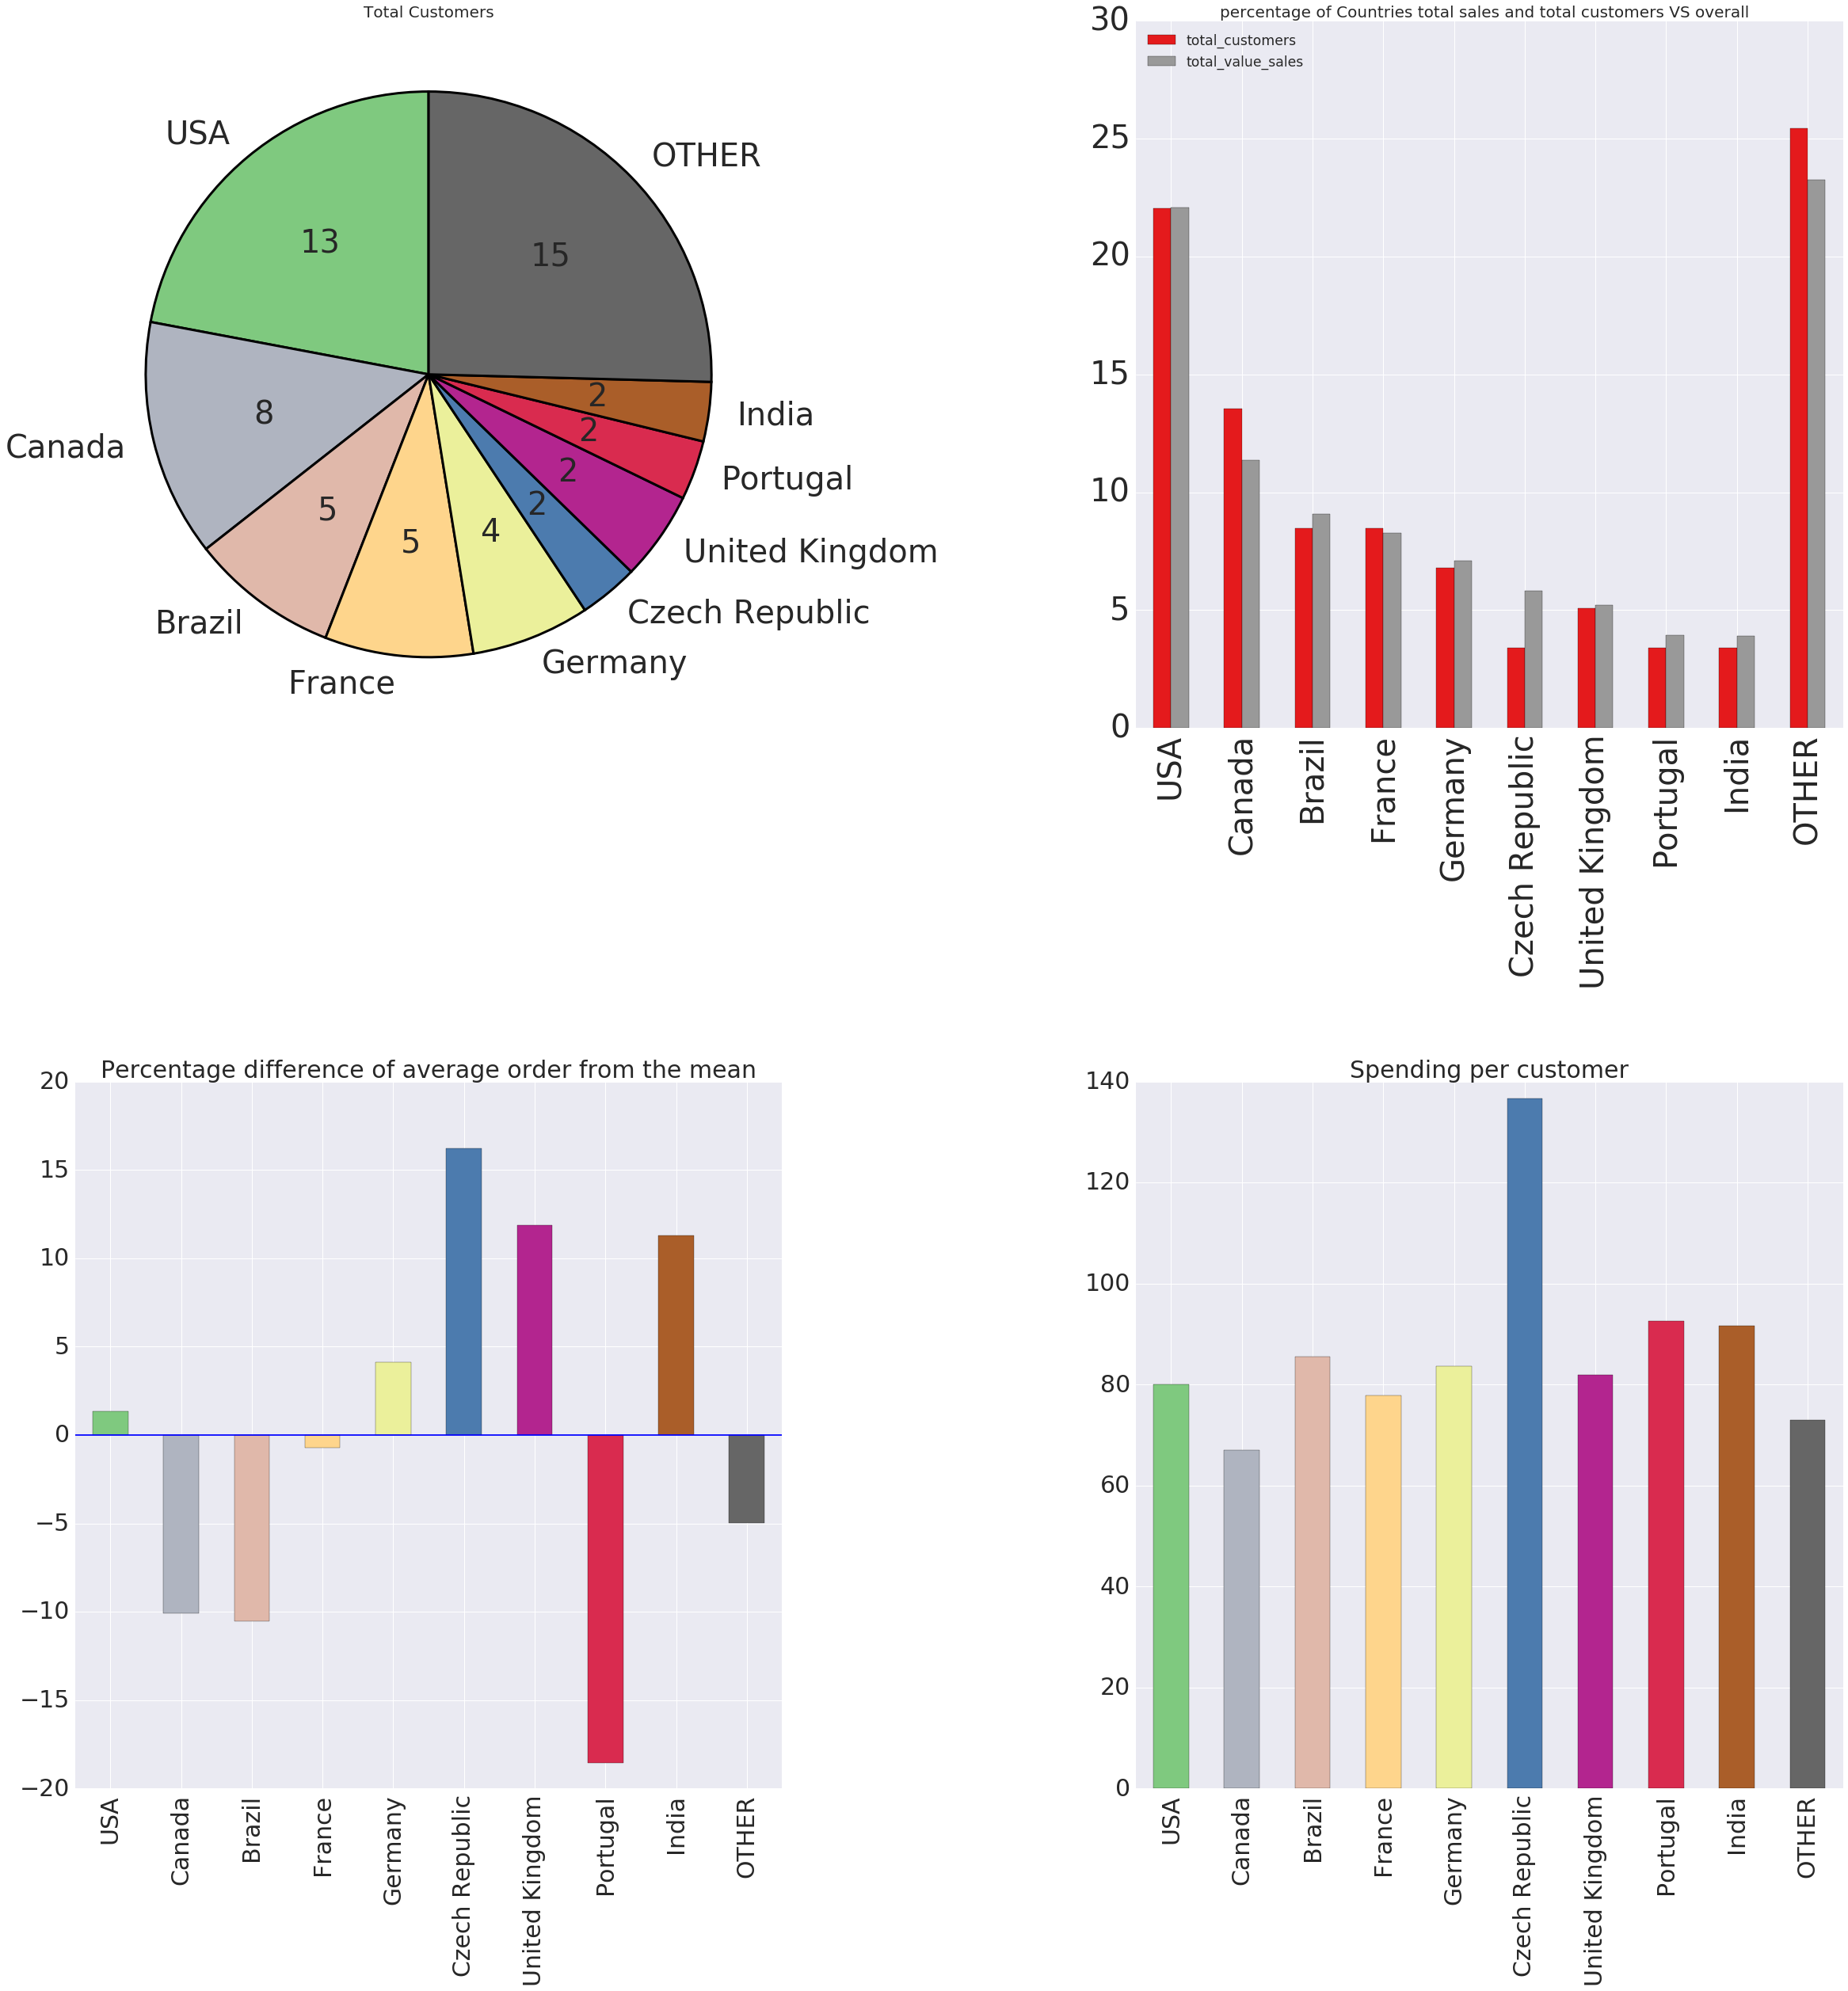

In [62]:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(40,40))
#flattens 2x2 array into 4x1 so can assign each of the 4 axes as below
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5,wspace=.5)
def absval(pct):
    total = int(pct/100*(country_data['total_customers'].sum()))
    return total


#top left
customers_per_country = country_data['total_customers'].copy()
customers_per_country.plot.pie(ax=ax1,
                           startangle=90,
                           wedgeprops={'linewidth':3},
                           fontsize=40,
                           autopct=absval,
                           colormap=plt.cm.Accent
                          )
ax1.set_ylabel('')
ax1.set_title('Total Customers', fontdict={'fontsize':20})

#top right
pct_cust_vs_pct_sales = country_data[['total_customers','total_value_sales']].copy()

for col in ['total_customers', 'total_value_sales']:
    pct_cust_vs_pct_sales[col] /= pct_cust_vs_pct_sales[col].sum()
    pct_cust_vs_pct_sales[col]*=100
    
pct_cust_vs_pct_sales.plot.bar(ax=ax2,
                              fontsize=40,
                               colormap=plt.cm.Set1
                              )
ax2.set_title('percentage of Countries total sales and total customers VS overall  ', fontdict={'fontsize':20})
ax2.legend(loc=2, fontsize='x-large')  
ax2.set_xlabel('')

# bottom left
avg_order_mean = country_data['avg_order_value'].mean()
pct_differences_from_mean = (country_data['avg_order_value']/avg_order_mean)*100 -100
pct_differences_from_mean.plot.bar(ax=ax3,
                                   color=colors,
                                  fontsize=30)
ax3.set_xlabel('')
ax3.set_title('Percentage difference of average order from the mean',fontdict={'fontsize':30})
ax3.axhline(0)


#bottom right
customer_spending=country_data['avg_sale_per_customer'].copy()
customer_spending.plot.bar(ax=ax4,
                           color=colors,
                          fontsize=30)
ax4.set_title('Spending per customer', fontdict={'fontsize':30})
ax4.set_xlabel('')



Looking at the data there are a few stand out observations. It should however be taken into consideration that many countries have 3 or less customers and those few customers might not be representative of the population of the country as a whole (statistics might suffer from some bias).
<br><br>
<b> The USA makes up the largest percentage of chinooks customers, not too far behind is Canada. <br><br>
Customers from Portugal spend relatively little 'per order' compared to the average (84%) whilst customers from Czech spend a great deal more than average (160%)
<br><br>

It appears that Czech, United Kingdom and India are good markets to advertise in based on the observations, despite each only having 2 representative customers, they do all spend a little more on average with each order.



# Are customers likely to buy whole albums?

The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:<br>

1 purchase a whole album<br>
2 purchase a collection of one or more individual tracks.<br>

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

The following information is given to us <br>
<b> The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually but we have been told this NEVER happens). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

## What we need to do 


effectively what we need to do for this task is to analyze each SEPERATE invoice and determine wether the customer bought the entire album or just a few tracks from it. The task has made way for a lot of confusion and it is my belief that the solution provided by dataquest (which has been copied below 'my solution' in a markdown cell).....is wrong. I will explain why<br>


making use of the above information we know that IF any single customer buys ONE entire album, THEN all other purchases made by that customer within the same invoice MUST also be entire albums(they cannot add single tracks from another album to the same invoice), basically each invoice is either made up of only singles OR only albums<br>
This means we really only need to check wether or not they have purchased ONE album to determine wether albums OR singles were purchased on each invoice. 
<br>



In [63]:
#my solution, calculate statistics for the absolute value and percentages of album purchases
query = '''

 WITH invoice_id_n_track_id AS
 (  SELECT
    il.invoice_id,
    t.track_id
    FROM invoice_line il INNER join track t ON t.track_id=il.track_id
    GROUP BY 1
 )
 
 SELECT
 album_purchase,
 CAST(COUNT(DISTINCT invoice_id) AS FLOAT)/CAST((select COUNT(*) FROM invoice) AS FLOAT) * 100 percentage,
 COUNT(invoice_id) invoice_amount
 FROM
 
 (
      SELECT 
      it.*,
      CASE
      WHEN 
          (
           SELECT 
           track_id
           FROM track
           WHERE album_id = (
                             SELECT album_id FROM track t2
                             WHERE t2.track_id = it.track_id
                             )
          
           EXCEPT
          
           SELECT
           il.track_id 
           FROM invoice_line il
           INNER JOIN track t ON il.track_id = t.track_id
           WHERE (il.invoice_id = it.invoice_id) AND 
           (album_id = (
                             SELECT album_id FROM track t2
                             WHERE t2.track_id = it.track_id
                             ))
          )IS NULL
           
          AND
           
          (
           SELECT
           il.track_id 
           FROM
           invoice_line il 
           INNER JOIN track t ON t.track_id = il.track_id
           WHERE (il.invoice_id = it.invoice_id)
           AND 
           (album_id = (
                             SELECT album_id FROM track t2
                             WHERE t2.track_id = it.track_id
                             ))
      
           EXCEPT
           
           SELECT 
           track_id FROM track
           WHERE album_id = (
                             SELECT album_id FROM track t2
                             WHERE t2.track_id = it.track_id
                             ) 
                
          )IS NULL
   
          THEN 'YES'
          ELSE 'NO'
          END AS album_purchase
 
      FROM
      invoice_id_n_track_id AS it
 )
 
 GROUP BY album_purchase
           
'''
run_query(query)

,album_purchase,percentage,invoice_amount
0,NO,78.013029,479
1,YES,21.986971,135


Considering 22% or one fifth of sales go towards albums it is recommended that the company continue to sell entire albums 

# Which solo artist appears in the most playlists?

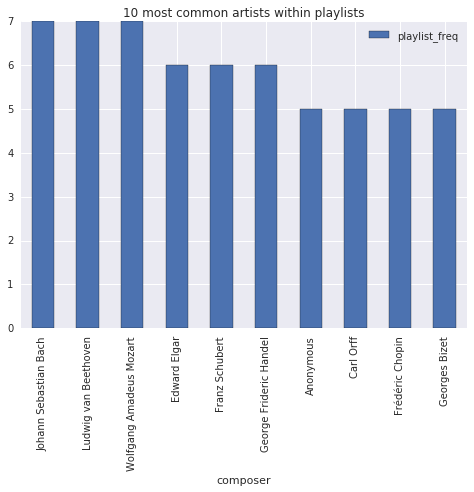

In [64]:
query= '''
       SELECT
       t.composer,
       COUNT(DISTINCT pt.playlist_id) playlist_freq
       FROM
       track t 
       INNER JOIN playlist_track pt ON pt.track_id = t.track_id
       WHERE t.composer != "None"
       GROUP BY 1
       ORDER BY 2 DESC
       
       '''
artist_playlist_data = run_query(query)
artist_playlist_data = artist_playlist_data.set_index('composer')
artist_playlist_data[:10].plot(kind='bar', title='10 most common artists within playlists')

By the looks of it, the SOLO artists whom appear in the most playlists are classical Musicians, This does not necesarrily indicate that the majority of playlist songs are by classical musicians however, just that out of all of the different playlists, these artists appear atleast once in the greatest amount of them. 

# How many tracks have been purchased vs not purchased?

Lets investigate the amount of songs in the store which have not been purchased and compare to the amount of songs from the store that have been purchased atleast once.

In [65]:
#total numbers of tracks been purhcased atleast once OR never
#sum total should be equal to total amount of tracks in track table
#Since invoice_line_id is the primary key of invoice_line table(it cannot be null or duplicate), When we left join invoice_line to track
#if invoice_line_id is null, then there were no matching sales for said track

alteast_one_purchase = run_query("""
          SELECT
          CASE
              WHEN
                 il.invoice_line_id IS NULL 
              THEN 'NO'
              ELSE 'YES'
              END AS '1_or_more_purchases',
          COUNT(DISTINCT t.track_id) total_tracks,
          CAST(COUNT(DISTINCT t.track_id) AS FLOAT)/CAST((SELECT COUNT(*) FROM track) AS FLOAT) * 100 percentage
          
          FROM track t
          LEFT JOIN 
          invoice_line il
          ON t.track_id = il.track_id
          GROUP BY 1""").set_index('1_or_more_purchases')

sum_total = alteast_one_purchase.sum(axis=0)
sum_total.name='sum_total'

alteast_one_purchase = alteast_one_purchase.append(sum_total)
check_against_total = run_query('SELECT COUNT(*) FROM track')
check_against_total.iloc[0,0] == alteast_one_purchase.loc['sum_total', 'total_tracks']


True

In [100]:
alteast_one_purchase

,total_tracks,percentage
1_or_more_purchases,,
NO,1697.0,48.444191
YES,1806.0,51.555809
sum_total,3503.0,100.000000


Almost 50 percent of the Tracks inside the store have never been purchased. If these tracks were replaced with more popular ones, sales would increase dramatically

# Dataquest suspect solution

Herein lies the steps used by dataquest:<br>
create a 'WITH' table which assigns ONLY ONE track_id to each seperate invoice_id (since we only need to determine if all tracks from ONE album are in the invoice we only need to select ONE track, and then find its respective album)
for each combination of the above, perform the following set operations and ensure they are BOTH empty, if they are both empty THEN the invoice contains ONLY albums <br>

SET A = (The set of all tracks purchased on the invoice using invoice_id) <br>
SET B = (The set of all tracks belonging to the album of the track_id) 
<br>

: A without B <br>
: B without A 

This logic breaks down when an invoice contains more than one ENTIRE album due to the fact that you could potentially have an invoice in which ALL(more than one) purchases were albums and so SET A would consist of all tracks from ALL of the albums but SET B would consist of only tracks belonging to ONE album (corresponding to the single track_id associated with the invoice_id). 
You could(and do) therefore have cases whereby an invoice consisting of multiple ENTIRE albums would be classified as ONLY singles since the first of the set operations above would return NOT empty(there would be tracks in A which are NOT in B)<br>

Using the fact that we only need to consider one album (because if a customer buys 1 entire album, they can ONLY buy more entire albums, not singles)...
<br>
SET A should be changed to ..... (The set of all tracks purchased on the invoice using invoice_id, ONLY WHERE THE ALBUM OF EACH TRACK IS THE SAME AS THE ASSOCIATED track_id)

In [68]:
#dataquests solution to album problem/task
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


# END
<br>
This project was quite a bit harder than the others i've encountered thus far and for that reason very adictive. 

# INGORE FOLLOWING CODE
<br>
Simply an alternative solution to album problem

In [ ]:
#my alternative solution
queer = '''

 WITH invoice_id_n_track_id AS
 (  SELECT
    il.invoice_id,
    t.album_id,
    t.track_id
    FROM invoice_line il INNER join track t ON t.track_id=il.track_id
    GROUP BY 1,2
 ),
 
 invoices_each_album AS
 (
 SELECT
 invoice_id,
 album_id,
 album_purchase
 FROM
 
 (
      SELECT 
      it.*,
      CASE
      WHEN 
          (
           SELECT 
           track_id
           FROM track
           WHERE album_id = (
                             SELECT album_id FROM track t2
                             WHERE t2.track_id = it.track_id
                             )
          
           EXCEPT
          
           SELECT
           il.track_id 
           FROM invoice_line il
           INNER JOIN track t ON il.track_id = t.track_id
           WHERE (il.invoice_id = it.invoice_id) AND 
           (album_id = (
                             SELECT album_id FROM track t2
                             WHERE t2.track_id = it.track_id
                             ))
          )IS NULL
           
          AND
           
          (
           SELECT
           il.track_id 
           FROM
           invoice_line il 
           INNER JOIN track t ON t.track_id = il.track_id
           WHERE (il.invoice_id = it.invoice_id)
           AND 
           (album_id = (
                             SELECT album_id FROM track t2
                             WHERE t2.track_id = it.track_id
                             ))
      
           EXCEPT
           
           SELECT 
           track_id FROM track
           WHERE album_id = (
                             SELECT album_id FROM track t2
                             WHERE t2.track_id = it.track_id
                             ) 
                
          )IS NULL
   
          THEN 1
          ELSE 0
          END AS album_purchase
 
      FROM
      invoice_id_n_track_id AS it 
 )
 )
 
 select
 album_buyer, 
 COUNT(invoice_id)
 FROM(
 select 
 invoice_id, 
 CASE
     WHEN SUM(album_purchase) = COUNT(distinct album_id)
     THEN 'YES'
     ELSE 'NO'
     
     END AS album_buyer
 from invoices_each_album
 
 group by invoice_id)
 group by album_buyer
 
           
'''
run_query(queer)